In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
from kaggle_util import *
from models import *

t_start = time.time()

Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

def build_model_deeper(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [3]:


# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=False)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [4]:
SUBSET = len(train_df)
train_df = train_df.head(SUBSET)
len(train_df)

4000

In [5]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
train_df.index.values,
np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3), 
np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
train_df.coverage.values,
train_df.z.values,
test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [6]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 3)
(800, 101, 101, 1)


In [7]:
start_feature = 32
batch_size = 32
dropout = 0.5
base_name = 'Unet_resnet_deeper_3channel_{}_{}_{}'.format(start_feature, batch_size, dropout)
basic_name = '../model/{}'.format(base_name)
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

# model
input_layer = Input((img_size_target, img_size_target, 3))
output_layer = build_model_deeper(input_layer, start_feature,dropout)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

board = keras.callbacks.TensorBoard(log_dir='log/{}'.format(base_name),
                       histogram_freq=0, write_graph=True, write_images=False)
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=3, min_lr=0.00001, verbose=1)

epochs = 200

history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[board, early_stopping, model_checkpoint,reduce_lr], 
                    verbose=1)

../model/Unet_resnet_deeper_3channel_32_32_0.5.model
../model/Unet_resnet_deeper_3channel_32_32_0.5.csv
Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 91s 14ms/step - loss: 0.4180 - my_iou_metric: 0.3596 - val_loss: 2.0638 - val_my_iou_metric: 0.1153

Epoch 00001: val_my_iou_metric improved from -inf to 0.11525, saving model to ../model/Unet_resnet_deeper_3channel_32_32_0.5.model
Epoch 2/200
6400/6400 [==============================] - 80s 12ms/step - loss: 0.3219 - my_iou_metric: 0.5254 - val_loss: 0.8461 - val_my_iou_metric: 0.3870

Epoch 00002: val_my_iou_metric improved from 0.11525 to 0.38700, saving model to ../model/Unet_resnet_deeper_3channel_32_32_0.5.model
Epoch 3/200
6400/6400 [==============================] - 80s 13ms/step - loss: 0.2774 - my_iou_metric: 0.5587 - val_loss: 0.4402 - val_my_iou_metric: 0.4912

Epoch 00003: val_my_iou_metric improved from 0.38700 to 0.49125, saving model to ../model/Unet_resnet_deeper_3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6400/6400 [==============================] - 80s 12ms/step - loss: 0.0598 - my_iou_metric: 0.8085 - val_loss: 0.1278 - val_my_iou_metric: 0.7784

Epoch 00055: val_my_iou_metric did not improve from 0.78412
Epoch 00055: early stopping


In [8]:
model1 = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.00001, verbose=1)
epochs = 200

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[board, model_checkpoint,reduce_lr,early_stopping], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 139s 22ms/step - loss: 0.0245 - my_iou_metric_2: 0.7639 - val_loss: 0.1300 - val_my_iou_metric_2: 0.7454

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.74537, saving model to ../model/Unet_resnet_deeper_3channel_32_32_0.5.model
Epoch 2/200
6400/6400 [==============================] - 127s 20ms/step - loss: -0.0217 - my_iou_metric_2: 0.7711 - val_loss: 0.1442 - val_my_iou_metric_2: 0.7411

Epoch 00002: val_my_iou_metric_2 did not improve from 0.74537
Epoch 3/200
6400/6400 [==============================] - 127s 20ms/step - loss: -0.0389 - my_iou_metric_2: 0.7734 - val_loss: 0.2376 - val_my_iou_metric_2: 0.7276

Epoch 00003: val_my_iou_metric_2 did not improve from 0.74537
Epoch 4/200
6400/6400 [==============================] - 127s 20ms/step - loss: -0.0629 - my_iou_metric_2: 0.7799 - val_loss: 0.1244 - val_my_iou_metric_2: 0.7436

Epoch 00004: val_my_iou_metric_2 did not 

6400/6400 [==============================] - 127s 20ms/step - loss: -0.4981 - my_iou_metric_2: 0.8676 - val_loss: -0.1591 - val_my_iou_metric_2: 0.8202

Epoch 00033: val_my_iou_metric_2 did not improve from 0.82400
Epoch 34/200
6400/6400 [==============================] - 127s 20ms/step - loss: -0.4905 - my_iou_metric_2: 0.8654 - val_loss: -0.1431 - val_my_iou_metric_2: 0.8147

Epoch 00034: val_my_iou_metric_2 did not improve from 0.82400
Epoch 35/200
6400/6400 [==============================] - 127s 20ms/step - loss: -0.4974 - my_iou_metric_2: 0.8673 - val_loss: -0.1458 - val_my_iou_metric_2: 0.8227

Epoch 00035: val_my_iou_metric_2 did not improve from 0.82400

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 36/200
6400/6400 [==============================] - 127s 20ms/step - loss: -0.5077 - my_iou_metric_2: 0.8693 - val_loss: -0.1377 - val_my_iou_metric_2: 0.8212

Epoch 00036: val_my_iou_metric_2 did not improve from 0.82400
Epoch 37/200
6400/64

6400/6400 [==============================] - 128s 20ms/step - loss: -0.5623 - my_iou_metric_2: 0.8817 - val_loss: -0.1116 - val_my_iou_metric_2: 0.8250

Epoch 00067: val_my_iou_metric_2 did not improve from 0.82725
Epoch 68/200
6400/6400 [==============================] - 128s 20ms/step - loss: -0.5679 - my_iou_metric_2: 0.8808 - val_loss: -0.1102 - val_my_iou_metric_2: 0.8234

Epoch 00068: val_my_iou_metric_2 did not improve from 0.82725
Epoch 69/200
6400/6400 [==============================] - 128s 20ms/step - loss: -0.5609 - my_iou_metric_2: 0.8799 - val_loss: -0.1098 - val_my_iou_metric_2: 0.8216

Epoch 00069: val_my_iou_metric_2 did not improve from 0.82725

Epoch 00069: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
Epoch 00069: early stopping


In [9]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})




[0.825    0.825125 0.825625 0.8265   0.827    0.82675  0.827    0.82725
 0.827375 0.827375 0.827375 0.8275   0.8275   0.827625 0.826875 0.826375
 0.827125 0.827375 0.82675  0.826125 0.82575  0.825625 0.825125 0.8245
 0.8245   0.824125 0.822125 0.821875 0.822875 0.822    0.822625]


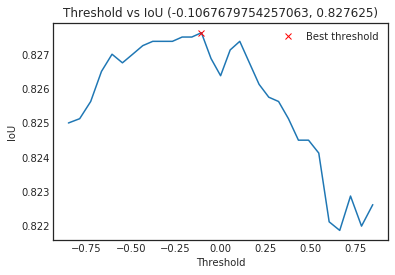

In [10]:
preds_valid = predict_result(model,x_valid,img_size_target)
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [11]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = predict_result(model,x_test,img_size_target)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


ValueError: Error when checking input: expected input_1 to have shape (101, 101, 3) but got array with shape (101, 101, 1)

In [ ]:
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub = sub.reset_index()
save_result(sub, '../result/{}.csv'.format(base_name), 
                        competition = 'tgs-salt-identification-challenge', 
                        send = True, index = False)

t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")